<a href="https://colab.research.google.com/github/vekoada/tensorflow-course/blob/main/04_transfer_learning_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import urllib.request
import zipfile
url = 'https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip'
filename = '10_food_classes_10_percent.zip'
file = urllib.request.urlretrieve(url, filename)
zip_ref = zipfile.ZipFile(filename)
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os
#Walk through directory and list number of files
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f"{len(dirnames)} directories and {len(filenames)} images in {dirpath}")

2 directories and 0 images in 10_food_classes_10_percent
10 directories and 0 images in 10_food_classes_10_percent/train
0 directories and 75 images in 10_food_classes_10_percent/train/pizza
0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
0 directories and 75 images in 10_food_classes_10_percent/train/sushi
0 directories and 75 images in 10_food_classes_10_percent/train/ramen
0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
0 directories and 75 images in 10_food_classes_10_percent/train/steak
10 directories and 0 images in 10_food_classes_10_percent/test
0 directories and 250 images in 10_food_classes_10_percent/test/pizza
0 direct

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                          target_size=IMAGE_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
import tensorflow as tf

In [ ]:
#Create a function to create TensorBoard callbacks for each model
import datetime
def tensorboard(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to {log_dir}")
  return callback

In [ ]:
#Using TensorFlow Hub - comparing two models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/google/efficientnet/b0/feature-vector/1'

In [ ]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons. Should be equal to number of classes. Default is 10 classes.

  Returns:
  An uncompiled Keras Sequential model with model_url as feature extractor
  layer and Dense output layer with num_classes output neurons.
  """
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, #Freeze existing learned patterns for now
                                           name='feature_extractor_layer',
                                           input_shape=IMAGE_SIZE + (3,)) #Adds another dimension (now should be (224, 224, 3))

  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

In [ ]:
#Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary() #Note that the only trainable parameters are in the output layer

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (K  (None, 2048)              23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
res_history = resnet_model.fit(train_data_10_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_10_percent),
                               validation_data = test_data_10_percent, #should have just named it test_data...
                               validation_steps=len(test_data_10_percent),
                               callbacks=[tensorboard(dir_name='tensorflow_hub',
                                                      experiment_name='resnet_v2_50')])

Saving TensorBoard log files to tensorflow_hub/resnet_v2_50/20230914-030611
Epoch 1/5
24/24 [==============================] - 26s 571ms/step - loss: 2.0930 - accuracy: 0.3160 - val_loss: 1.2787 - val_accuracy: 0.5940
Epoch 2/5
24/24 [==============================] - 12s 528ms/step - loss: 0.9396 - accuracy: 0.7293 - val_loss: 0.8988 - val_accuracy: 0.7032
Epoch 3/5
24/24 [==============================] - 13s 547ms/step - loss: 0.6384 - accuracy: 0.8307 - val_loss: 0.7702 - val_accuracy: 0.7544
Epoch 4/5
24/24 [==============================] - 11s 457ms/step - loss: 0.4924 - accuracy: 0.8747 - val_loss: 0.7251 - val_accuracy: 0.7688
Epoch 5/5
24/24 [==============================] - 11s 459ms/step - loss: 0.3987 - accuracy: 0.9173 - val_loss: 0.6708 - val_accuracy: 0.7788


In [ ]:
#Way better than our models and in faster time and in only 10% of training data!

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
  """
  Returns separated loss curves for metrics
  """
  loss=history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  #Loss plot
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  plt.figure()
  #Accuracy Plot
  plt.plot(epochs, accuracy, label='accuracy')
  plt.plot(epochs, val_acc, label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

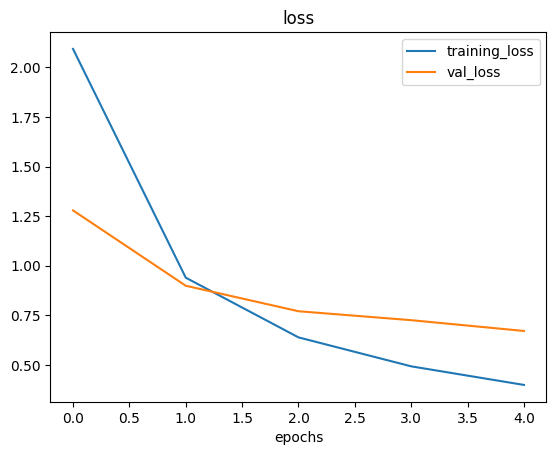

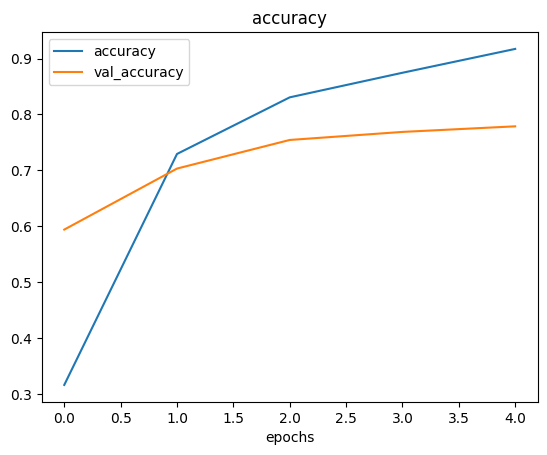

In [ ]:
plot_loss(res_history)

In [ ]:
#Create EfficientNet model
efficientnet_model = create_model(model_url=efficientnet_url)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (K  (None, 1280)              4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [ ]:
efficientnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
eff_history = efficientnet_model.fit(train_data_10_percent,
                                     epochs=5,
                                     steps_per_epoch=len(train_data_10_percent),
                                     validation_data=test_data_10_percent,
                                     validation_steps=len(test_data_10_percent),
                                     callbacks=[tensorboard(dir_name='tensorflow_hub', experiment_name='efficientnet_b0')]
                                     )

Saving TensorBoard log files to tensorflow_hub/efficientnet_b0/20230914-035333
Epoch 1/5
24/24 [==============================] - 17s 501ms/step - loss: 1.9120 - accuracy: 0.4147 - val_loss: 1.3187 - val_accuracy: 0.7160
Epoch 2/5
24/24 [==============================] - 10s 438ms/step - loss: 1.0874 - accuracy: 0.7760 - val_loss: 0.8634 - val_accuracy: 0.8108
Epoch 3/5
24/24 [==============================] - 16s 681ms/step - loss: 0.7654 - accuracy: 0.8347 - val_loss: 0.6911 - val_accuracy: 0.8392
Epoch 4/5
24/24 [==============================] - 10s 430ms/step - loss: 0.6101 - accuracy: 0.8507 - val_loss: 0.6048 - val_accuracy: 0.8516
Epoch 5/5
24/24 [==============================] - 10s 445ms/step - loss: 0.5152 - accuracy: 0.8907 - val_loss: 0.5512 - val_accuracy: 0.8624


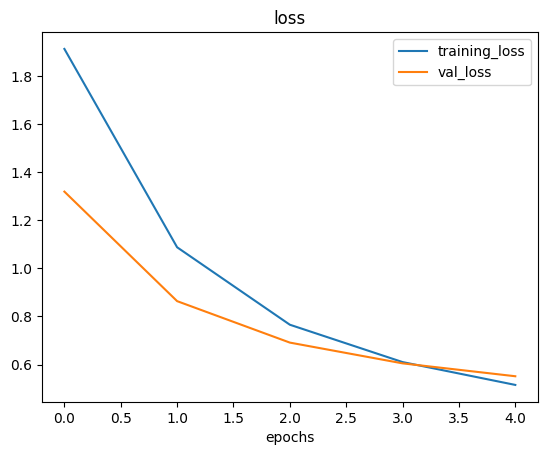

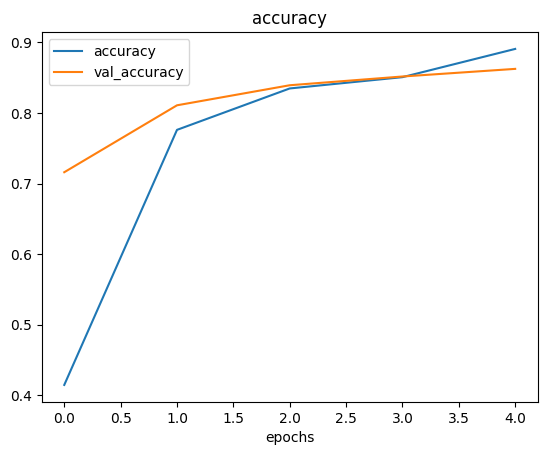

In [ ]:
plot_loss(eff_history) #nearly 10% better than resnet on validation data

In [ ]:
#Upload tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientNetB0 v.s. ResNetV250" \
--description "Comparing two different TF Hub feature extraction model architectures using 10% of original data" \
--one_shot

2023-09-14 04:10:50.300373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   LPYL-TSZM



New experiment created. View your TensorBoard at: https://tensorboard.dev/expe

In [ ]:
#Here are our experiments: https://tensorboard.dev/experiment/d8gLBGnsRvW5dpzKNHJqyQ/#scalars

In [ ]:
#See what experiments we have
!tensorboard dev list #!tensorboard dev delete --experiment_id d8gLBGnsRvW5dpzKNHJqyQ

2023-09-14 04:14:45.076922: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/d8gLBGnsRvW5dpzKNHJqyQ/
	Name                 EfficientNetB0 v.s. ResNetV250
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of original data
	Id                   d8gLBGnsRvW5dpzKNHJqyQ
	Created              2023-09-14 04:12:08 (2 minutes ago)
	Updated              2023-09-14 04:12:11 (2 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  3386612
Total: 1 experiment(s)
